In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
df = pd.read_csv('data/crash_reporting_drivers_data_sanitized.csv')
df

,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,...,Vehicle Movement,Vehicle Continuing Dir,Vehicle Going Dir,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,Montgomery County Police,Property Damage Crash,2019-05-31 15:00:00,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,NaN,NaN,...,PARKING,North,North,2004-01-01,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,Montgomery County Police,Property Damage Crash,2019-05-24 17:00:00,NaN,NaN,NaN,NaN,PARKING LOT,NaN,NaN,...,PARKING,Unknown,Unknown,2000-01-01,UNK,UNK,NaN,39.199047,-77.250743,"(39.19904667, -77.25074333)"
2,Montgomery County Police,Property Damage Crash,2023-07-17 10:45:00,County,SELFRIDGE RD,County,RANDOLPH RD,NaN,NaN,NaN,...,MOVING CONSTANT SPEED,East,East,2003-01-01,FORD,TK,NO MISUSE,39.054588,-77.085974,"(39.05458848, -77.08597423)"
3,Montgomery County Police,Property Damage Crash,2023-07-20 23:40:00,Maryland (State),MUNCASTER MILL RD,County,SHADY GROVE RD,NaN,NaN,NaN,...,MAKING RIGHT TURN,South,East,2023-01-01,TOYOTA,CP,NO MISUSE,39.148721,-77.147111,"(39.14872076, -77.14711061)"
4,Gaithersburg Police Depar,Property Damage Crash,2023-07-13 17:40:00,Municipality,PERRY PKWY,Unknown,ENT TO SHOPPING CENTER,NaN,NaN,NaN,...,MOVING CONSTANT SPEED,Unknown,Unknown,2001-01-01,KENWORTH,TRUCK,NaN,39.149085,-77.210731,"(39.14908542, -77.21073135)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167794,Takoma Park Police Depart,Property Damage Crash,2016-03-01 10:01:00,Municipality,NEW HAMPSHIRE SERVICE LA,Municipality,PRINCE GEORGES AVE,NaN,TAKOMA PARK,NaN,...,SLOWING OR STOPPING,East,East,2016-01-01,FORD,EXPLORER,NO MISUSE,38.972560,-76.997466,"(38.97255976, -76.99746609)"
167795,Montgomery County Police,Property Damage Crash,2017-07-19 14:22:00,County,CEDAR LA,Maryland (State),OLD GEORGETOWN RD,NaN,NaN,NaN,...,SLOWING OR STOPPING,East,East,2008-01-01,NISSAN,ALTIMA,NO MISUSE,39.004640,-77.108502,"(39.00464, -77.10850167)"
167796,Montgomery County Police,Property Damage Crash,2020-11-23 07:37:00,Maryland (State),RIDGE RD,Unknown,LITTLE SENECA PKWY,NaN,NaN,NaN,...,SLOWING OR STOPPING,North,North,2008-01-01,CHEVROLET,EXPRESS,NO MISUSE,39.228963,-77.236757,"(39.22896333, -77.23675667)"
167797,Montgomery County Police,Property Damage Crash,2019-11-23 23:23:00,County,SHADY GROVE RD,Ramp,RAMP 9 FR IS 370 EB TO SHADY GROVE RD,NaN,NaN,NaN,...,MAKING LEFT TURN,East,South,2018-01-01,FORD,TRANSIT VAN,NO MISUSE,39.120440,-77.180047,"(39.12043995, -77.18004738)"


In [3]:
df.columns

Index(['Agency Name', 'ACRS Report Type', 'Crash Date/Time', 'Route Type',
       'Road Name', 'Cross-Street Type', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Driver At Fault', 'Injury Severity',
       'Circumstance', 'Driver Distracted By', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Second Impact Location',
       'Vehicle Body Type', 'Vehicle Movement', 'Vehicle Continuing Dir',
       'Vehicle Going Dir', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model',
       'Equipment Problems', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

### Utils

In [4]:
def display_unique_values(df,col, max=True):
    if col not in df.columns:
        print(f"{col} not in dataframe")
        return
    if not max:
        print(df[col].value_counts())
    else:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df[col].value_counts())

    print(f"\nLength of Unique Values: {len(df[col].value_counts())}")
    print(f"\nColumn Length: {len(df[col])}")
    print('NA values: ', df[col].isna().sum())

# Defining colors, background, style and fonts for all the plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fonts = ['Arial', 'Calibri', 'Times New Roman', 'Verdana', 'Helvetica']
styles = ['whitegrid', 'dark', 'white', 'ticks']
backgrounds = ['white', 'lightgray', 'lightblue', 'lightyellow', 'lightgreen']

## BAR CHARTS

In [5]:
def plot_bar_chart(column_name, title, xlabel, ylabel):
    # Randomly select a color, font, style, and background
    # color = random.choice(colors)
    color_palette = sns.color_palette("hls", len(df[column_name].unique()))
    style = 'darkgrid'
    background = 'darkgray'

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bar chart
    ax = df[column_name].value_counts().plot(kind='bar', color=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

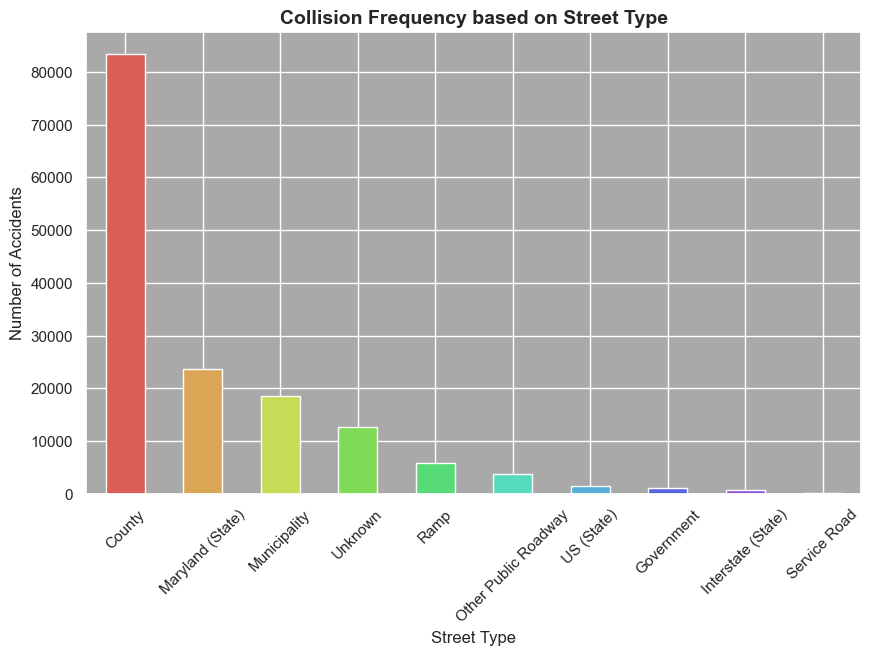

Cross-Street Type
County                  83448
Maryland (State)        23693
Municipality            18564
Unknown                 12678
Ramp                     5768
Other Public Roadway     3714
US (State)               1449
Government               1150
Interstate (State)        662
Service Road               91
Name: count, dtype: int64

Length of Unique Values: 10

Column Length: 167799
NA values:  16582


In [6]:
plot_bar_chart(
    column_name="Cross-Street Type",
    title="Collision Frequency based on Street Type",
    xlabel="Street Type",
    ylabel="Number of Accidents"
    )

display_unique_values(df, 'Cross-Street Type')

## Frequency Analysis

In [7]:
def plot_stacked_bar_chart(column_name, stacked_column, title, xlabel, ylabel, show_values=False):
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    fonts = "Helvetica"
    style = 'darkgrid'
    background = "lightgray"
    # color_palette = sns.color_palette("Set2", len(df[column_name].unique()))  # dark, muted, pastel, bright, deep, colorblind
    # color_palette = sns.hls_palette(len(df[column_name].unique()))
    # color_palette = sns.color_palette("viridis", len(df[column_name].unique()))
    # color_palette = sns.color_palette("hls", len(df[column_name].unique()))
    # color_palette = sns.color_palette("tab20", len(df[column_name].unique()))
    color_palette = sns.color_palette([
    "#1f77b4",  # muted blue
    "#ff7f0e",  # safety orange
    "#2ca02c",  # cooked asparagus green
    "#d62728",  # brick red
    "#9467bd",  # muted purple
    "#8c564b",  # chestnut brown
    "#e377c2",  # raspberry yogurt pink
    "#7f7f7f",  # middle gray
    "#bcbd22",  # curry yellow-green
    "#17becf"   # blue-teal
])
    
    # custom_colors = [["#9b59b6", "#3498db", "#95a5a6"]]
    # color_palette = sns.color_palette(custom_colors)
    # custom_palette = sns.color_palette(["#9b59b6", "#3498db", "#95a5a6"])
    sns.set_palette(color_palette)

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bar chart
    ax = df.groupby(column_name)[stacked_column].value_counts().unstack().plot(kind='bar', stacked=True, color=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend.set_title(stacked_column, prop={'size': 11})

    # Add data labels to the stacked bar chart
    if show_values:
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height}', (x + width/2, y + height/2), ha='center', va='center')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=60)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

### Combination 1 : 1) ACRS Report Type x Route Type

<Figure size 1000x600 with 0 Axes>

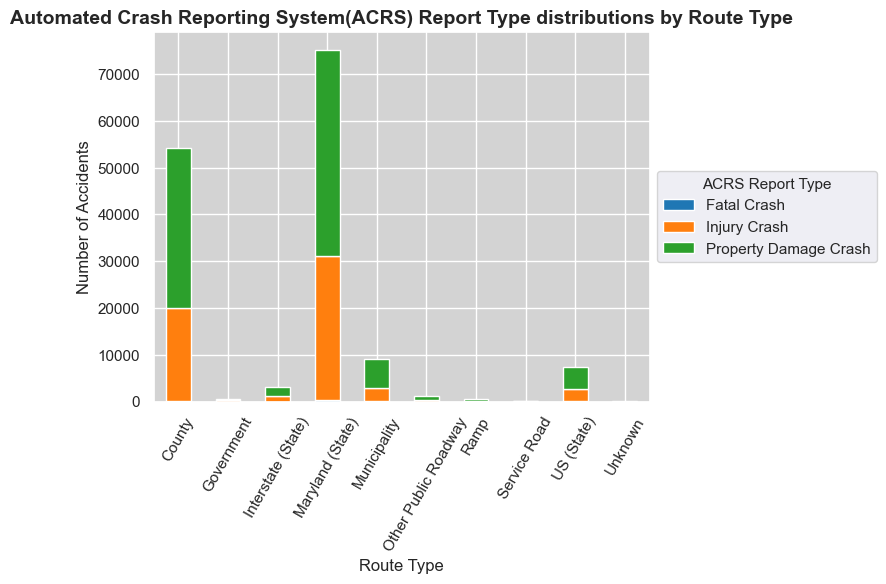

In [8]:
# Bar chart stacked by Route Type to compare ACRS Report Type distributions.
plot_stacked_bar_chart("Route Type", "ACRS Report Type", "Automated Crash Reporting System(ACRS) Report Type distributions by Route Type", "Route Type", "Number of Accidents")

### Combination 1 : 2)Weather x Surface Condition

In [9]:
def scatter_plots(column_name, title, xlabel, ylabel, size_column, color_column, data=df): ## For numerical data
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    style = 'darkgrid'
    background = random.choice(backgrounds)

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bubble chart
    ax = sns.scatterplot(x=column_name, y=size_column, size=size_column, hue=color_column, data=df)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

def balloon_plot(x_column, y_column, title, xlabel, ylabel, data=df, size_column=None, color_column=None, size=(50, 500), rotation=45):
    # Randomly select a color, style, and background
    style = 'darkgrid'
    background = 'darkgray'
    color_palette = None if color_column is None else sns.color_palette("Set2", len(df[color_column].unique()))

    # sns.set(style=style)  # Set the style of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the balloon chart
    if size_column is None and color_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, data=data)
    elif size_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, hue=color_column, data=data, palette=color_palette)
    elif color_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, sizes=size, data=data)
    else:
        ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, hue=color_column, sizes=size, data=data, palette=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=rotation)
    
    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/3202249067.py:48: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, hue=color_column, sizes=size, data=data, palette=color_palette)


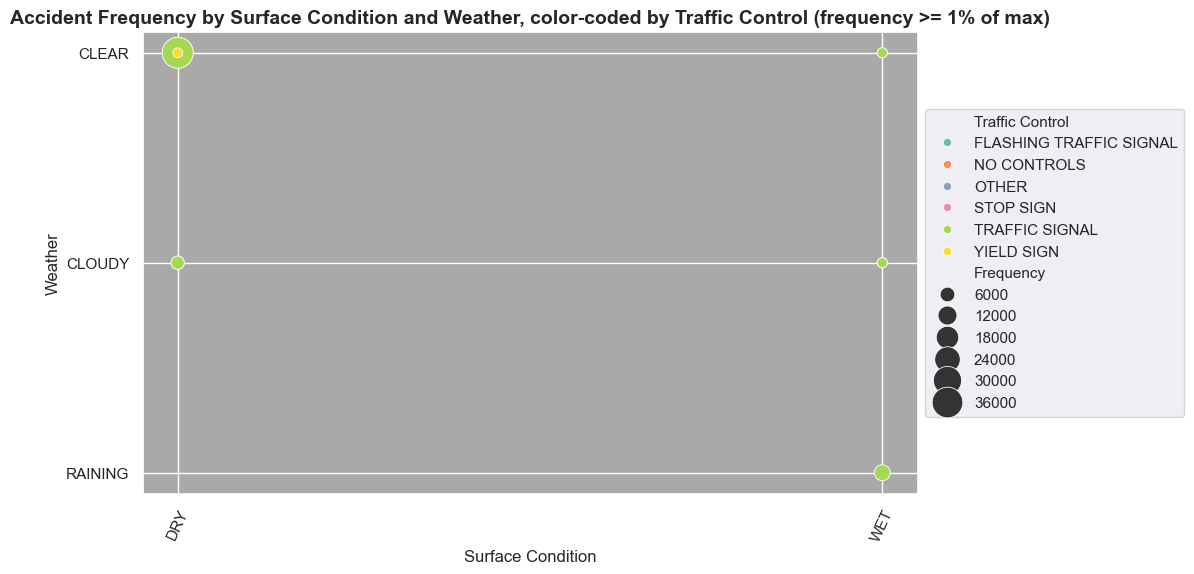

Surface Condition  Weather  Traffic Control          Frequency
DRY                CLEAR    FLASHING TRAFFIC SIGNAL  1243         1
                            NO CONTROLS              36489        1
                            OTHER                    1138         1
                            STOP SIGN                7387         1
                            TRAFFIC SIGNAL           36992        1
                            YIELD SIGN               1081         1
                   CLOUDY   NO CONTROLS              4436         1
                            STOP SIGN                1021         1
                            TRAFFIC SIGNAL           4274         1
WET                CLEAR    NO CONTROLS              1298         1
                            TRAFFIC SIGNAL           1132         1
                   CLOUDY   NO CONTROLS              1406         1
                            TRAFFIC SIGNAL           1255         1
                   RAINING  NO CONTROLS              

In [10]:
# Bubble chart with bubble size proportional to accident frequency, color-coded by Traffic Control, and positioned based on Surface Condition and Light.
df_12 = df.groupby(['Surface Condition', 'Weather', 'Traffic Control']).size().reset_index(name='Frequency')
df_12_filtered = df_12[df_12['Frequency'] >= 0.01 * df_12['Frequency'].max()]
df_12_filtered
# df_12

balloon_plot(
    x_column='Surface Condition',
    y_column='Weather', 
    title='Accident Frequency by Surface Condition and Weather, color-coded by Traffic Control (frequency >= 1% of max)', 
    xlabel='Surface Condition', 
    ylabel='Weather', 
    size_column='Frequency',
    color_column='Traffic Control',
    rotation=65,
    data=df_12_filtered
    )
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # print(df_12.value_counts())
    print(df_12_filtered.value_counts())

### Combination 1 : 3) Drivers at fault vs substance abuse for both drivers and non-motorists.

In [11]:
# Pie chart or stacked bar chart to visualize the proportion of drivers at fault, with suspected substance abuse for both drivers and non-motorists.

def pie_chart(column_name1, column_name2, title, data=df):
    # Randomly select a color, font, style, and background
    # color = random.choice(colors)
    # style = 'darkgrid'
    # background = 'darkgray'

    # sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the pie chart
    ax = df.groupby([column_name1, column_name2]).size().unstack().plot(kind='pie', subplots=True, autopct='%1.1f%%', startangle=90)

    # Set the title
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Set the background color
    # ax.set_facecolor(background)

    # Show the plot
    plt.show()

In [12]:
# pie_chart(
#     column_name1='Driver Substance Abuse',
#     column_name2='Non-Motorist Substance Abuse',
#     title='Proportion of drivers at fault, with suspected substance abuse for both drivers and non-motorists'
#     )

/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/2008588744.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df.set_index(datetime_column).resample('M').size(), "r--", color='black')


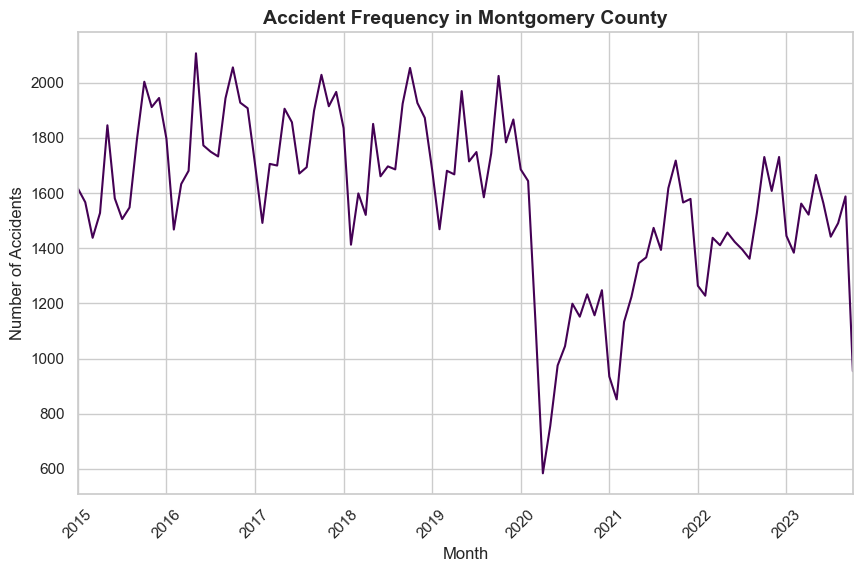

In [13]:
def plot_line_chart(datetime_column, title, xlabel, ylabel):
    # Randomly select a color, font, style, and background
    # color = random.choice(colors)
    color_palette = sns.color_palette("viridis", len(df[datetime_column].unique()))
    # color_palette = sns.color_palette("hls", len(df[datetime_column].unique()))
    style = 'whitegrid'
    background = 'white'

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Convert the datetime column to a pandas datetime object
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Plot the line chart
    ax = df.set_index(datetime_column).resample('M').size().plot(kind='line', color=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # # Add a trendline
    # z = np.polyfit(range(len(df)), df.set_index(datetime_column).resample('M').size(), 1)
    # p = np.poly1d(z)
    plt.plot(df.set_index(datetime_column).resample('M').size(), "r--", color='black')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

plot_line_chart(
    datetime_column='Crash Date/Time',
    title='Accident Frequency in Montgomery County',
    xlabel='Month',
    ylabel='Number of Accidents'
)


/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/838874600.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_new, y_new, "r--", color='black')


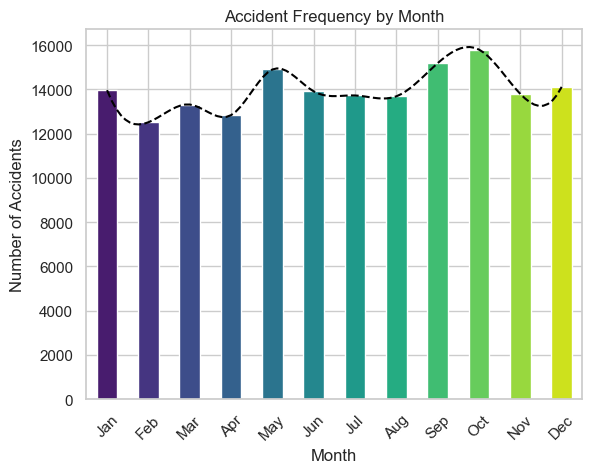

<Figure size 1000x600 with 0 Axes>

In [14]:
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

df['Month'] = df['Crash Date/Time'].dt.month

df['Month'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette("viridis", len(df['Month'].unique())))
plt.title('Accident Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')

# Replace the x-axis tick labels with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(len(month_names)), month_names, rotation=45)

# Get the sorted counts of accidents for each month
accident_counts = df['Month'].value_counts().sort_index()

# Plot a curve that passes through all the data points
x = np.arange(len(accident_counts))
y = accident_counts.values
f = interp1d(x, y, kind='cubic')
x_new = np.linspace(0, len(accident_counts) - 1, 100)
y_new = f(x_new)
plt.plot(x_new, y_new, "r--", color='black')
plt.figure(figsize=(10, 6))

plt.show()

/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/1475687513.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/crash_reporting_drivers_data.csv')
/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/1475687513.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_new, y_new, "r--", color='black')


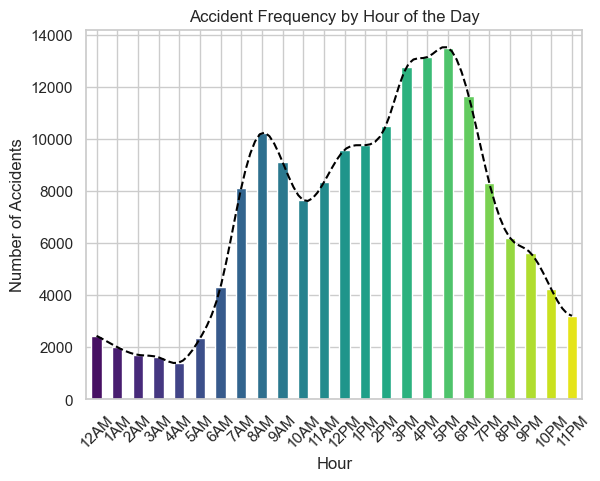

<Figure size 1000x600 with 0 Axes>

In [15]:
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

df = pd.read_csv('data/crash_reporting_drivers_data.csv')
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'], format='%m/%d/%Y %I:%M:%S %p')
df['Crash Date/Time'].dt.hour.value_counts().sort_index().plot(kind='bar', color=sns.color_palette("viridis", len(df['Crash Date/Time'].dt.hour.unique())))

plt.title('Accident Frequency by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')

# Replace the x-axis tick labels with hour values
hour_labels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
plt.xticks(range(len(hour_labels)), hour_labels, rotation=45)

# Get the sorted counts of accidents for each hour
accident_counts = df['Crash Date/Time'].dt.hour.value_counts().sort_index()

# Plot a curve that passes through all the data points
x = np.arange(len(accident_counts))
y = accident_counts.values
f = interp1d(x, y, kind='cubic')
x_new = np.linspace(0, len(accident_counts) - 1, 100)
y_new = f(x_new)
plt.plot(x_new, y_new, "r--", color='black')
plt.figure(figsize=(10, 6))

plt.show()

In [16]:
# display a heatmap of the correlation matrix

def plot_heatmap(df, title):
    # Randomly select a color, font, style, and background
    # color = random.choice(colors)
    # style = 'darkgrid'
    # background = 'darkgray'

    # sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the heatmap
    ax = sns.heatmap(df.corr(), annot=True, cmap='viridis')

    # Set the title
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Set the background color
    # ax.set_facecolor(background)

    # Show the plot
    plt.show()

/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/1489353228.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/crash_reporting_drivers_data.csv')


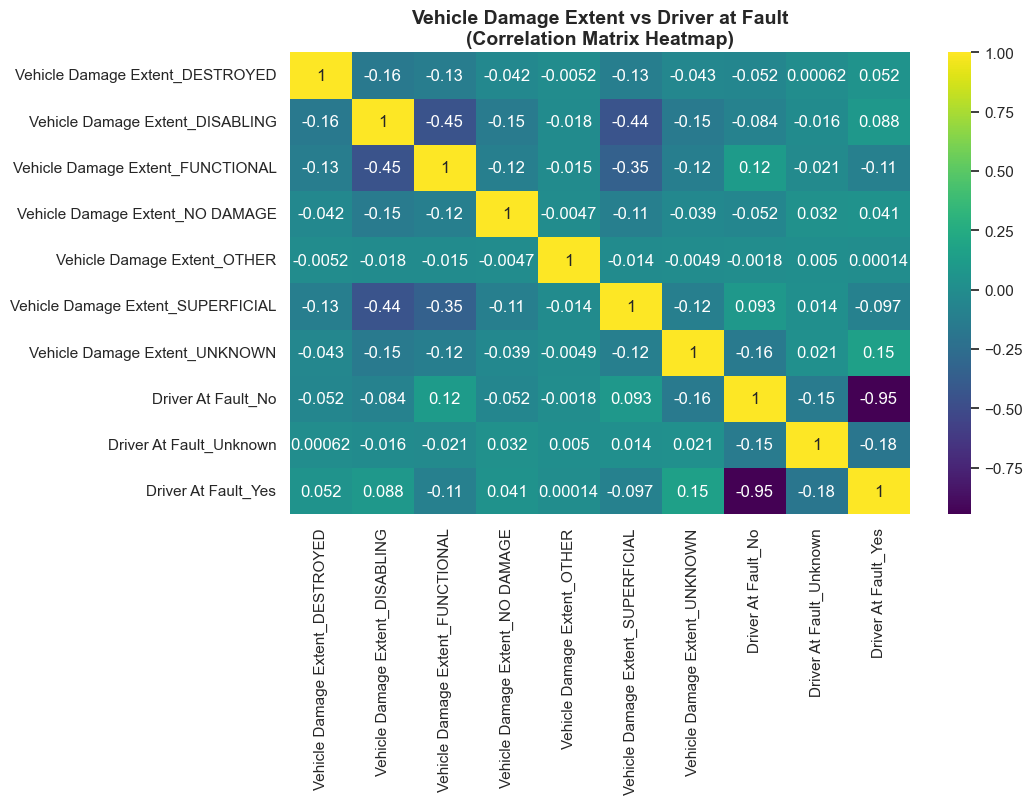

In [17]:
df = pd.read_csv('data/crash_reporting_drivers_data.csv')
heatmap_df = df[["Vehicle Damage Extent", "Driver At Fault"]]


# Convert categorical variable to binary indicators
df_binary = pd.get_dummies(heatmap_df)
df_binary.corr()

plot_heatmap(df_binary, 'Vehicle Damage Extent vs Driver at Fault\n(Correlation Matrix Heatmap)')

In [18]:
def plot_multiple_line_chart(df, datetime_column, attribute_column, title, xlabel, ylabel):
    # color_palette = sns.color_palette("viridis", len(df[attribute_column].unique()))
    color_palette = sns.color_palette("hls", len(df[datetime_column].unique()))
    style = 'whitegrid'
    background = 'white'

    sns.set(style=style)
    plt.figure(figsize=(14, 6))

    # df[datetime_column] = pd.to_datetime(df[datetime_column])
    # if df[datetime_column].dtype != 'datetime64[ns]':
    #     df[datetime_column] = pd.to_datetime(df[datetime_column], format='%m/%d/%Y %I:%M:%S %p')

    ax = df.groupby([datetime_column, attribute_column]).size().unstack().plot(kind='line', color=color_palette)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    plt.xticks(rotation=45)

    ax.set_facecolor(background)

    # Get the unique values from the attribute_column for the legend
    # unique_values = df[attribute_column].unique()
    # ax.legend(unique_values)

    # Sort the unique values
    sorted_unique_values = sorted(df[attribute_column].unique())

    # Set the sorted unique values as the legend labels
    # ax.legend(sorted_unique_values)
    # # Move the legend to the right side of the plot
    # legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # legend.set_title("attribute_column", prop={'size': 11})

    # Create the legend with the sorted_unique_values labels and move it to the right side of the plot
    legend = ax.legend(sorted_unique_values, loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the title for the legend
    legend.set_title(attribute_column, prop={'size': 11})

    plt.show()

/var/folders/97/nt8v7kl11hgf9sbb8jrhrdlm0000gn/T/ipykernel_81164/1890434978.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/crash_reporting_drivers_data.csv')


<Figure size 1400x600 with 0 Axes>

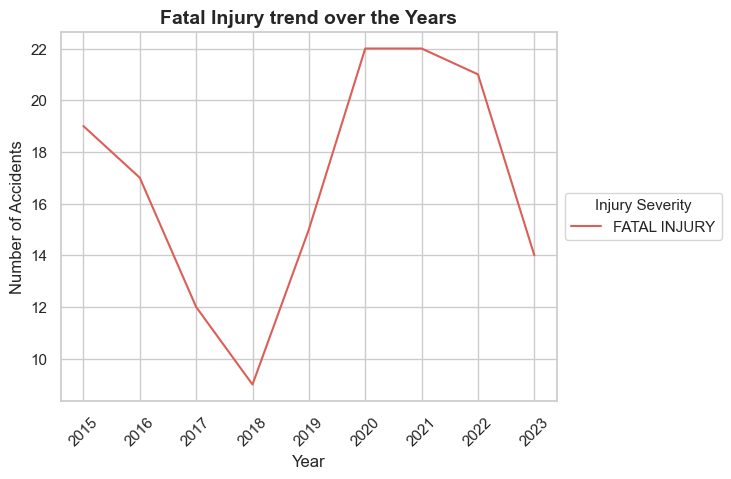

In [19]:
df = pd.read_csv('data/crash_reporting_drivers_data.csv')

df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'], format='%m/%d/%Y %I:%M:%S %p')
df["Year"] = df['Crash Date/Time'].dt.year
# df.groupby(['Year', 'ACRS Report Type']).size()

# plot_multiple_line_chart(df, 'Year', 'Injury Severity', 'Injury Severity trend over the Years', 'Year', 'Number of Accidents')
# plot_multiple_line_chart(df, 'Year', 'ACRS Report Type', 'Types of ACRS Reports over the Years', 'Year', 'Number of Accidents')

df_temp = df[df["Injury Severity"] == "FATAL INJURY"]
# df_temp
plot_multiple_line_chart(df_temp, 'Year', 'Injury Severity', 'Fatal Injury trend over the Years', 'Year', 'Number of Accidents')

In [20]:
def plot_clustered_bar_plot(df, group_column, stacked_column, title, xlabel, ylabel):
    # color_palette = sns.color_palette("viridis", len(df[stacked_column].unique()))
    # color_palette = sns.color_palette("hls", len(df[stacked_column].unique()))
    color_palette = sns.color_palette([
    "#1f77b4",  # muted blue
    "#ff7f0e",  # safety orange
    "#2ca02c",  # cooked asparagus green
    "#d62728",  # brick red
    "#9467bd",  # muted purple
    "#8c564b",  # chestnut brown
    "#e377c2",  # raspberry yogurt pink
    "#7f7f7f",  # middle gray
    "#bcbd22",  # curry yellow-green
    "#17becf"   # blue-teal
])
    sns.set_palette(color_palette)
    style = 'whitegrid'
    background = 'white'

    sns.set(style=style)

    # Create a figure and axes with constrained layout
    fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

    df.groupby([group_column, stacked_column]).size().unstack().plot(kind='bar', ax=ax, color=color_palette)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    plt.xticks(rotation=45)

    ax.set_facecolor(background)

    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend.set_title(stacked_column, prop={'size': 11})

    plt.show()

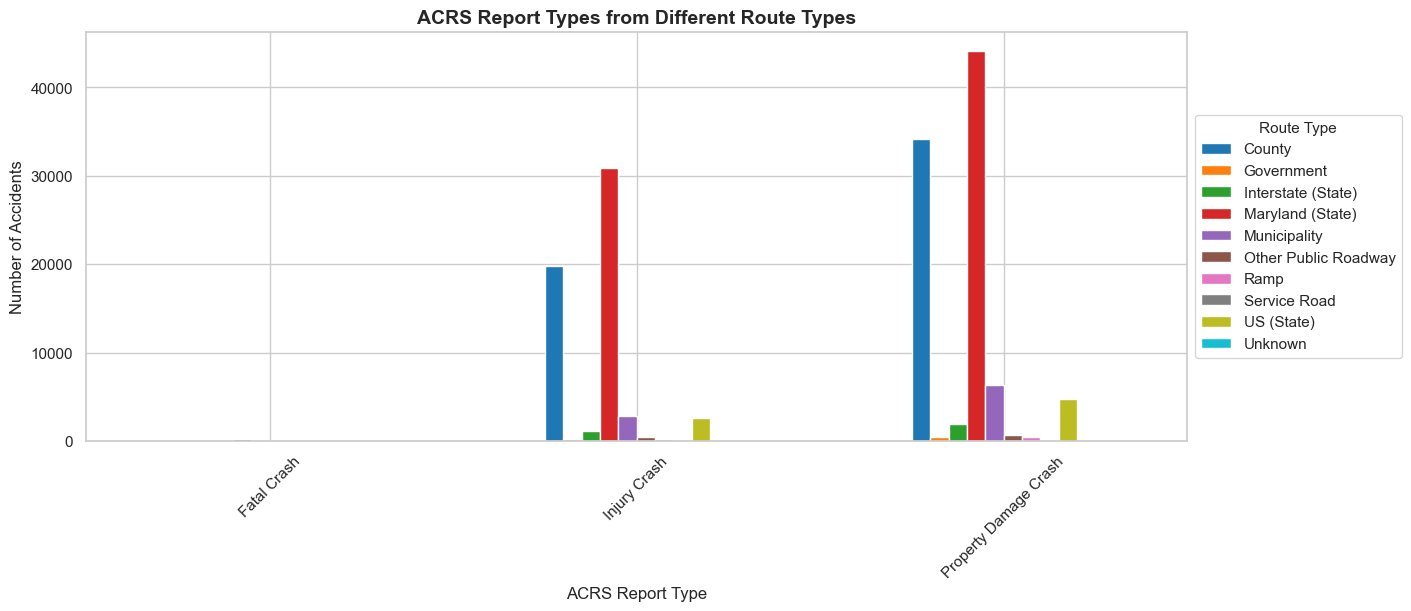

In [21]:
plot_clustered_bar_plot(df, 'ACRS Report Type', 'Route Type', 'ACRS Report Types from Different Route Types', 'ACRS Report Type', 'Number of Accidents')

<Figure size 1000x600 with 0 Axes>

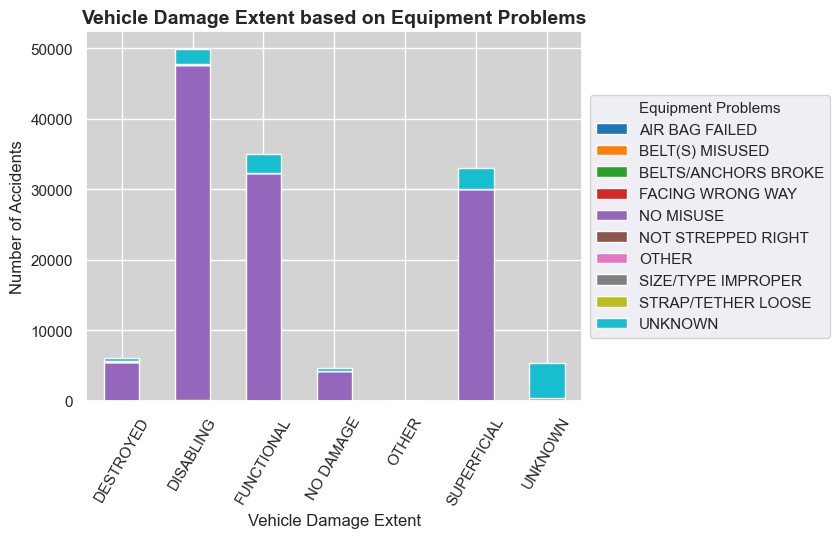

In [22]:
# Bar chart stacked by Vehicle Body Type to compare Vehicle Damage Extent distributions.
plot_stacked_bar_chart("Vehicle Damage Extent", "Equipment Problems", "Vehicle Damage Extent based on Equipment Problems", "Vehicle Damage Extent", "Number of Accidents")

In [26]:
# # Bubble chart with bubble size proportional to accident frequency, color-coded by Traffic Control, and positioned based on Surface Condition and Light.
# df_13 = df.groupby(['ACRS Report Type', 'Route Type']).size().reset_index(name='Frequency')
# df_13_filtered = df_13[df_13['Frequency'] >= 0.01 * df_13['Frequency'].max()]
# # df_12_filtered = df_13[df_13['Frequency'] >= 0.01 * df_13['Frequency'].max()]
# # df_12_filtered
# # # df_12

# balloon_plot(
#     x_column='ACRS Report Type',
#     y_column='Route Type', 
#     title='Accident Frequency by Route Type and ACRS Report Type, color-coded by Traffic Control (frequency >= 1% of max)', 
#     xlabel='ACRS Report Type', 
#     ylabel='Route Type', 
#     size_column='Frequency',
#     color_column='Frequency',
#     rotation=65,
#     data=df_13_filtered
#     )
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     # print(df_12.value_counts())
#     print(df_13_filtered.value_counts())

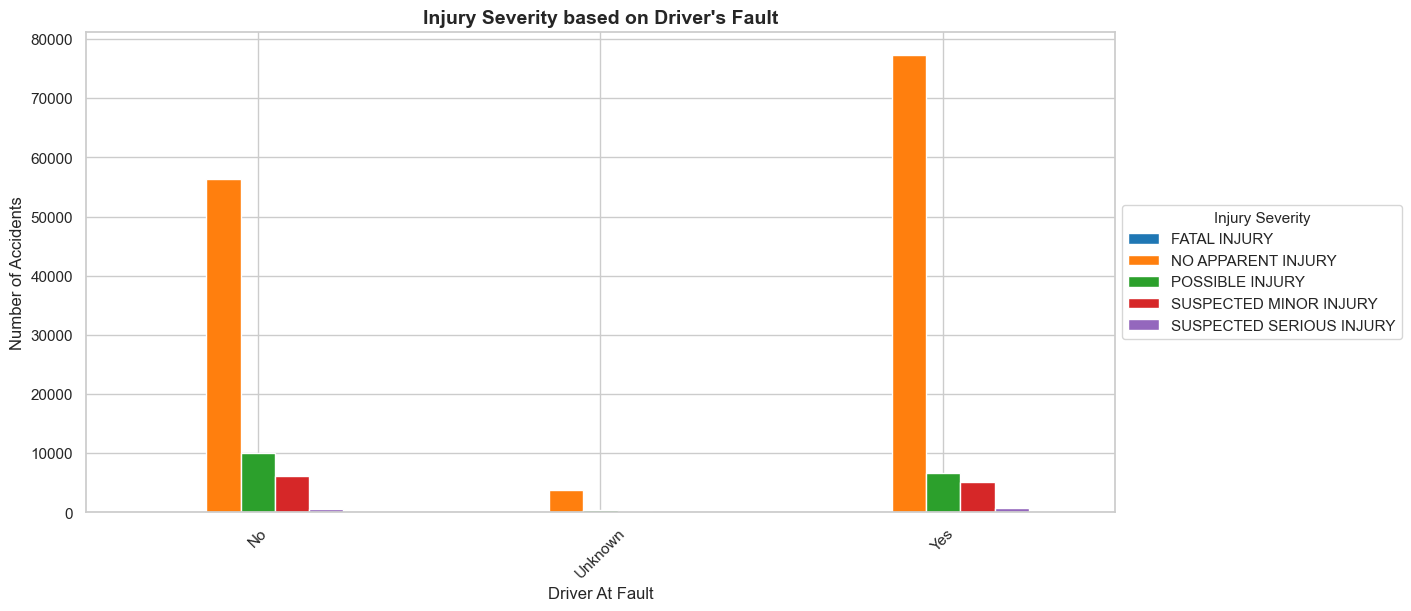

In [ ]:
plot_clustered_bar_plot(df, 'Driver At Fault', 'Injury Severity', "Injury Severity based on Driver's Fault", 'Driver At Fault', 'Number of Accidents')

In [25]:
import plotly.graph_objects as go
import plotly.offline as pyo

theta_categories_data = df["Vehicle First Impact Location"].unique().tolist() 
theta_categories_data.append(theta_categories_data[0])

circle_categories_data = df["Vehicle Damage Extent"].unique().tolist()
# circle_categories_data.append(circle_categories_data[0])

# print(circle_categories_data)

fig = go.Figure()

clock_values = {"THREE OCLOCK": 3, 'TWO OCLOCK': 2, 'ONE OCLOCK': 1, 'TWELVE OCLOCK': 12, 'ELEVEN OCLOCK': 11, 'TEN OCLOCK': 10, 'NINE OCLOCK': 9, 'EIGHT OCLOCK': 8, 'SEVEN OCLOCK': 7, 'SIX OCLOCK': 6, 'FIVE OCLOCK': 5, 'FOUR OCLOCK': 4}

for category in circle_categories_data:
    # vals = df[df["Vehicle Damage Extent"] == category]["Vehicle First Impact Location"].values.flatten().tolist()
    vals = df[df["Vehicle Damage Extent"] == category]["Vehicle First Impact Location"].value_counts().to_dict()
    total_len = sum(vals.values())
    
    print("\n_______________________\n")
    print(f"\n{category} : \t {total_len} Unique Values")
    
    order_vals = {}

    for key in clock_values:
        # print(f"\n{key}")
        if key in vals.keys():
            percent = round((vals[key] / total_len) *100)
            # print(f"{key}: {percent}")
            order_vals[key] = percent
        else:
            order_vals[key] = 0
            # print(f"{percent}")
    
    # clock_values_list = [1 if key in vals else 0 for key in clock_values]

        radar_data = list(order_vals.values())
    
    # clock_values_list.append(clock_values_list[0])
    fig.add_trace(go.Scatterpolar(
        r=radar_data,  # radar_data
        theta=list(clock_values.keys()),
        fill='toself',
        name=category
    ))

fig.update_layout(
    title="Vehicle First Impact Location vs Vehicle Damage Extent",
    polar={'radialaxis': {'visible': True}},
    showlegend=True
)

pyo.plot(fig)



_______________________


SUPERFICIAL : 	 42808 Unique Values

_______________________


FUNCTIONAL : 	 43867 Unique Values

_______________________


DISABLING : 	 60733 Unique Values

_______________________


DESTROYED : 	 7368 Unique Values

_______________________


nan : 	 0 Unique Values

_______________________


UNKNOWN : 	 6431 Unique Values

_______________________


NO DAMAGE : 	 6039 Unique Values

_______________________


OTHER : 	 96 Unique Values


'temp-plot.html'

In [ ]:
def generate_radar_plot(df, theta_col, category_col):
    theta_categories_data = df[theta_col].unique().tolist() 
    theta_categories_data.append(theta_categories_data[0])

    circle_categories_data = df[category_col].unique().tolist()

    fig = go.Figure()

    clock_values = {"THREE OCLOCK": 3, 'TWO OCLOCK': 2, 'ONE OCLOCK': 1, 'TWELVE OCLOCK': 12, 'ELEVEN OCLOCK': 11, 'TEN OCLOCK': 10, 'NINE OCLOCK': 9, 'EIGHT OCLOCK': 8, 'SEVEN OCLOCK': 7, 'SIX OCLOCK': 6, 'FIVE OCLOCK': 5, 'FOUR OCLOCK': 4}

    for category in circle_categories_data:
        vals = df[df[category_col] == category][theta_col].value_counts().to_dict()
        total_len = sum(vals.values())

        order_vals = {}

        for key in clock_values:
            if key in vals.keys():
                percent = round((vals[key] / total_len) *100)
                order_vals[key] = percent
            else:
                order_vals[key] = 0

        radar_data = list(order_vals.values())

        fig.add_trace(go.Scatterpolar(
            r=radar_data,
            theta=list(clock_values.keys()),
            fill='toself',
            name=category
        ))

    fig.update_layout(
        title=f"{theta_col} vs {category_col}",
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )

    pyo.plot(fig)


In [ ]:
generate_radar_plot(df, "Vehicle First Impact Location", "Vehicle Damage Extent")
generate_radar_plot(df, "Vehicle Second Impact Location", "Vehicle Damage Extent")